# Automatic box prompt all data

import packages

In [1]:
%matplotlib ipympl
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from skimage import io, transform
import torch
from torch.nn import functional as F
from ipywidgets import interact, widgets
import ipympl
import glob
import cv2
from segment_anything import sam_model_registry
from utils.SurfaceDice import compute_dice_coefficient, compute_surface_distances, compute_average_surface_distance

In [15]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load model

In [16]:

model_path = 'D:\\Stage\\MedSAM' 
MedSAM_CKPT_PATH = model_path + "\\medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### Some functions

In [2]:
def  normalization(modality, image_data):
    """ Normalizes CT or MRI data """
    #%%Normalization
    if modality =='CT':
        lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
        upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (
                (image_data_pre - np.min(image_data_pre))
                / (np.max(image_data_pre) - np.min(image_data_pre))
                * 255.0)
    else:
        lower_bound, upper_bound = np.percentile(
                        image_data[image_data > 0], 0.5
                    ), np.percentile(image_data[image_data > 0], 99.5)
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (
                        (image_data_pre - np.min(image_data_pre))
                        / (np.max(image_data_pre) - np.min(image_data_pre))
                        * 255.0
                    )           
        image_data_pre[image_data == 0] = 0

    image_data_pre = np.uint8(image_data_pre)

    return image_data_pre

In [3]:
def reshape(image_data_pre):
    """ Turn gray image into RGB image """
    #%% Reshape
    if len(image_data_pre.shape) == 2:
        img_3c = np.repeat(image_data_pre[:, :, None], 3, axis=-1)
    else:
        img_3c = image_data_pre
    H, W, _ = img_3c.shape

    return img_3c, H, W

def resize(img_3c):
    """ Resizes image of 3 channels into 1024x1024 pixels"""
    img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant').astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device))
    return img_1024, img_1024_tensor

def resize_mask(mask):
    """ Resizes mask into mask of 1024x1024 pixels"""
    mask_1024 = transform.resize(
    mask, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant').astype(np.uint8)
    mask_1024 = (mask_1024 - mask_1024.min()) / np.clip(mask_1024.max() - mask_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    return mask_1024

In [32]:
def create_box_prompt(mask):
    """ Creates box prompt from resized ground truth mask"""
    foreground_indices = np.argwhere(mask == 1)  # returns coordinates of all points where mask == 1
    if len(foreground_indices) == 0:
        raise ValueError("No foreground points found in the mask.")

    #plt.figure()
    #plt.scatter(foreground_indices[:,1], foreground_indices[:,0])
    #plt.show()

    x_min = np.min(foreground_indices[:,1])
    x_max = np.max(foreground_indices[:,1])
    y_min = np.min(foreground_indices[:,0])
    y_max = np.max(foreground_indices[:,0])

    bbox = np.array([x_min, y_min, x_max, y_max])

    return x_min, x_max, y_min, y_max, bbox

def show_box_prompt(mask, x_min, x_max, y_min, y_max, ax):
    
    # Define the 4 corner points
    top_left = (y_min, x_min)
    top_right = (y_max, x_min)
    bottom_left = (y_min, x_max)
    bottom_right = (y_max, x_max)
    
    # Create the array of 4 points
    box_points = [top_left, top_right, bottom_left, bottom_right]
    box_points = np.array(box_points)

    width = x_max - x_min
    height = y_max - y_min
    
    ax.clear()
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    
    ax.imshow(mask)
    plt.axis('off')

    #ax.scatter(box_points[:, 1], box_points[:, 0], color='green', marker='*', s=100, edgecolor='white', linewidth=1)
    ax.add_patch(rect)
    plt.draw()
    plt.show()


In [5]:
def save_seg(segmentation, image_path, slice_nr):
    """ Saves segmentation result in parent folder per slice"""
    parent_folder = os.path.dirname(image_path)
    # Create the output path inside the parent folder
    base_name = os.path.basename(image_path).split('.')[0]  # Get base name without extension
    out_path = os.path.join(parent_folder, f"{base_name}_slice_{slice_nr}_seg_result.png")

    #out_path_segs = f"{image_path.split('.')[0]}_slice_{slice_nr}_segs.png"
    cv2.imwrite(out_path, segmentation*255)

In [6]:
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, bbox, H, W):
    #scale_to_1024 = 1024 / np.array([W, H, W, H])
    #box_1024 = bbox * scale_to_1024

    #bbox_torch = torch.as_tensor(bbox_1024, dtype=torch.float).unsqueeze(0).to(self.model.device)
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=img_embed.device).unsqueeze(0)
    
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [7]:
def show_mask(mask, ax, random_color=False, alpha=0.3):
    #mask_foreground = np.argwhere(mask == 1)
    #if random_color:
        #color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    #else:
        #color = np.array([30/255, 144/255, 255/255, 0.6])
    #h, w = mask_foreground.shape[-2:]
    #mask_image = mask_foreground.reshape(h, w, 1) * color.reshape(1, 1, -1)

     # Create a mask image with the same shape as the original image
    mask_image = np.zeros((*mask.shape, 3))  # Shape (height, width, 3) for RGB

    if random_color:
        color = np.random.random(3)  # Random RGB color
    else:
        color = np.array([30/255, 144/255, 255/255])  # Example fixed color (blue)

    # Apply the color to the mask where it's non-zero
    mask_image[mask == 1] = color  # Set color at mask positions
    
    ax.imshow(mask_image, cmap='Reds', alpha=alpha)

In [8]:
def calculate_iou(mask1, mask2):
    """
    Calculates the Intersection over Union (IoU) between two binary masks.

    Args:
    - mask1: 2D binary numpy array (e.g., ground truth mask).
    - mask2: 2D binary numpy array (e.g., predicted mask).

    Returns:
    - iou: Intersection over Union as a float.
    """
    # Ensure the masks are boolean (0 and 1)
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    # Calculate intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return np.NaN  # Avoid division by zero, return NaN if both masks are empty
    
    iou = intersection / union
    return iou

### Load data

In [9]:
image_folder_path = "D:/Stage/Pancreas_dataset/t2/imagesTr"
mask_path = "D:/Stage/Pancreas_dataset/t2/labelsTr"
modality='MRI'
# Use glob to find all .nii files in the folder
nii_files = glob.glob(f"{image_folder_path}/*.nii/*.nii")
mask_files = glob.glob(f"{mask_path}/*.nii/*.nii")

# Create a dictionary to map image file names (without path or extension) to the full paths
image_dict = {os.path.basename(nii_file).split('.')[0]: nii_file for nii_file in nii_files}
mask_dict = {os.path.basename(mask_file).split('.')[0]: mask_file for mask_file in mask_files}

## Process data

In [11]:
# Loop over images

for nii_file in nii_files:
    # Extract the image name (without extension) and remove '_0000' suffix if present
    image_name = os.path.basename(nii_file).split('.')[0].replace('_0000', '')
    
    if image_name in mask_dict:  # Check if there is a matching mask file
        mask_path = mask_dict[image_name]

        # Load the image and corresponding mask
        image = nib.load(nii_file).get_fdata()
        mask = nib.load(mask_path).get_fdata()


        for slice_nr in range(image.shape[2]):
            image_data = image[:,:,slice_nr]
            mask_data = mask[:,:,slice_nr]

            if np.sum(mask_data == 1) >= 100:
                print(f"Processing slice {slice_nr} of image {image_name}")

                #Preprocessing    
                image_data_pre = normalization(modality, image_data)
                img_3c, H, W = reshape(image_data_pre)

                img_1024, img_1024_tensor = resize(img_3c)

                mask_1024 = resize_mask(mask_data)

                x_min, x_max, y_min, y_max, box_prompt = create_box_prompt(mask_1024)

                fig, ax = plt.subplots(figsize=(10,10))
                #show_box_prompt(mask_1024, x_min, x_max, y_min, y_max, ax)
                with torch.no_grad():
                    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)


                medsam_seg = medsam_inference(medsam_model, image_embedding, box_prompt, H, W)
                if np.any(medsam_seg != 0):
                    print("The mask contains non-zero values.")
                    save_seg(medsam_seg, mask_path, slice_nr)
                    medsam_seg_resized = resize_mask(medsam_seg)

                    #plt.figure(figsize=(10,10))
                    #plt.imshow(img_1024)
                    #show_mask(medsam_seg_resized, plt.gca())
                    #plt.axis('off')
                    #plt.show() 
                else:
                    print("The mask does not contain any non-zero values.")
       
            else:
                print(f"Skipping slice {slice_nr} of image {image_name}: Not enough mask pixels")
    
    else:
            print(f"Warning: No corresponding mask found for {image_name}")
    


Skipping slice 0 of image AHN_0001: Not enough mask pixels
Skipping slice 1 of image AHN_0001: Not enough mask pixels
Skipping slice 2 of image AHN_0001: Not enough mask pixels
Skipping slice 3 of image AHN_0001: Not enough mask pixels
Skipping slice 4 of image AHN_0001: Not enough mask pixels
Skipping slice 5 of image AHN_0001: Not enough mask pixels
Skipping slice 6 of image AHN_0001: Not enough mask pixels
Skipping slice 7 of image AHN_0001: Not enough mask pixels
Skipping slice 8 of image AHN_0001: Not enough mask pixels
Skipping slice 9 of image AHN_0001: Not enough mask pixels
Skipping slice 10 of image AHN_0001: Not enough mask pixels
Skipping slice 11 of image AHN_0001: Not enough mask pixels
Processing slice 12 of image AHN_0001
[370 497 434 550]
The mask contains non-zero values.
Processing slice 13 of image AHN_0001
[370 489 434 538]
The mask contains non-zero values.
Processing slice 14 of image AHN_0001
[375 449 477 562]
The mask contains non-zero values.
Processing slice 

Skipping slice 0 of image AHN_0001: Not enough mask pixels
Skipping slice 1 of image AHN_0001: Not enough mask pixels
Skipping slice 2 of image AHN_0001: Not enough mask pixels
Skipping slice 3 of image AHN_0001: Not enough mask pixels
Skipping slice 4 of image AHN_0001: Not enough mask pixels
Skipping slice 5 of image AHN_0001: Not enough mask pixels
Skipping slice 6 of image AHN_0001: Not enough mask pixels
Skipping slice 7 of image AHN_0001: Not enough mask pixels
Skipping slice 8 of image AHN_0001: Not enough mask pixels
Skipping slice 9 of image AHN_0001: Not enough mask pixels
Skipping slice 10 of image AHN_0001: Not enough mask pixels
Skipping slice 11 of image AHN_0001: Not enough mask pixels
Processing slice 12 of image AHN_0001
[370 497 434 550]


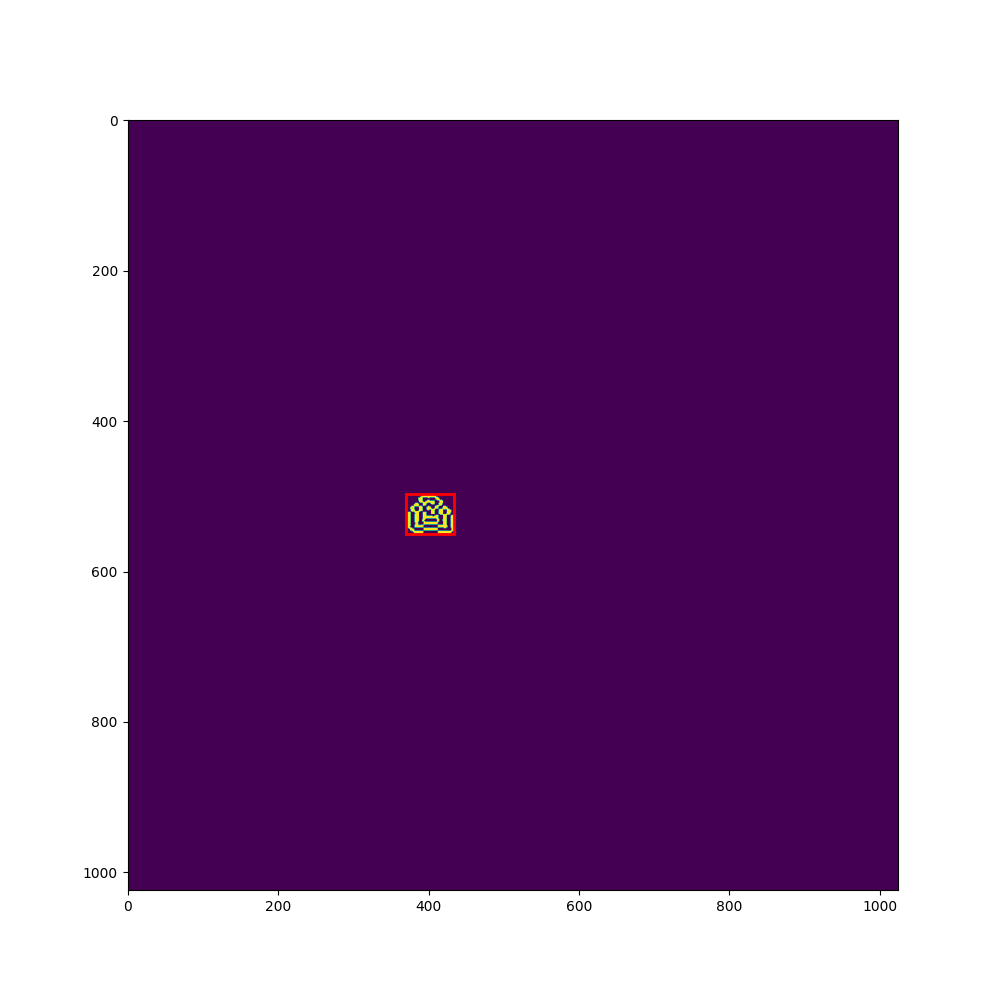

The mask contains non-zero values.
Processing slice 13 of image AHN_0001
[370 489 434 538]


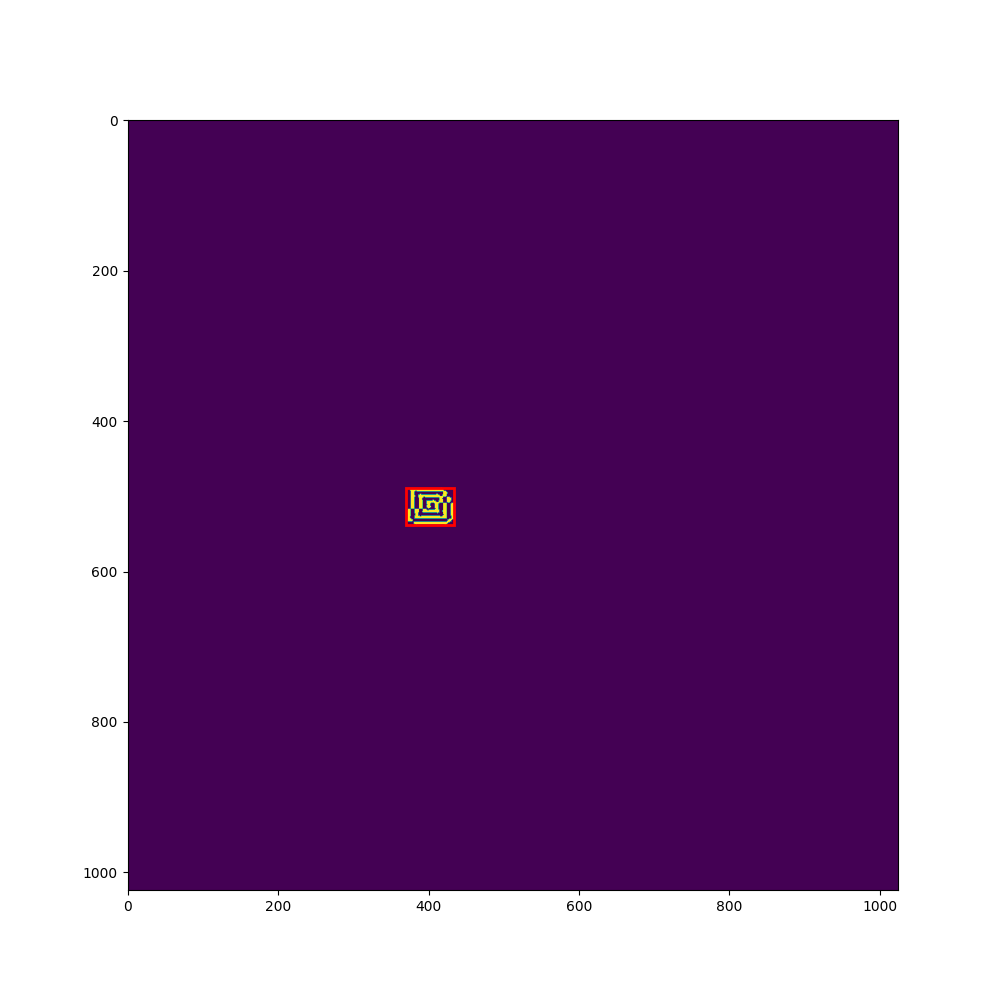

The mask contains non-zero values.
Processing slice 14 of image AHN_0001
[375 449 477 562]


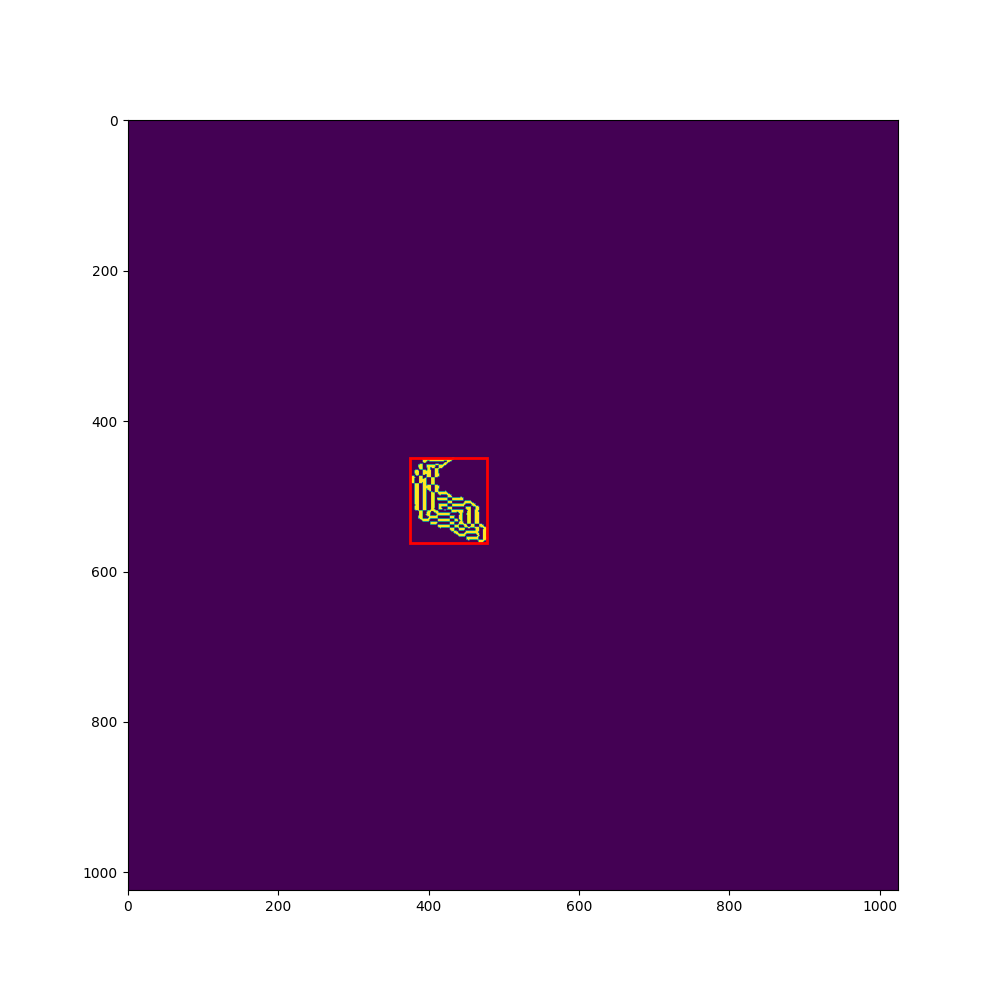

The mask contains non-zero values.
Processing slice 15 of image AHN_0001
[381 433 477 542]


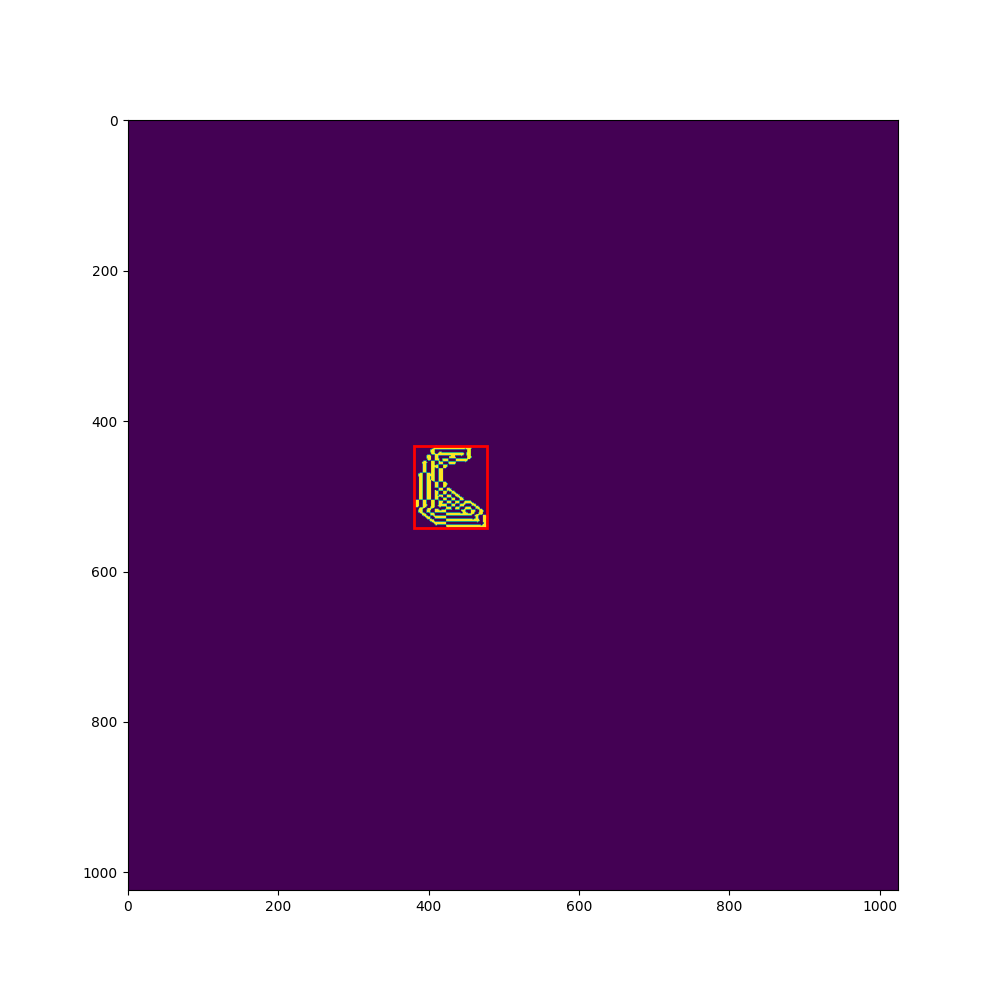

The mask contains non-zero values.
Processing slice 16 of image AHN_0001
[382 430 488 558]


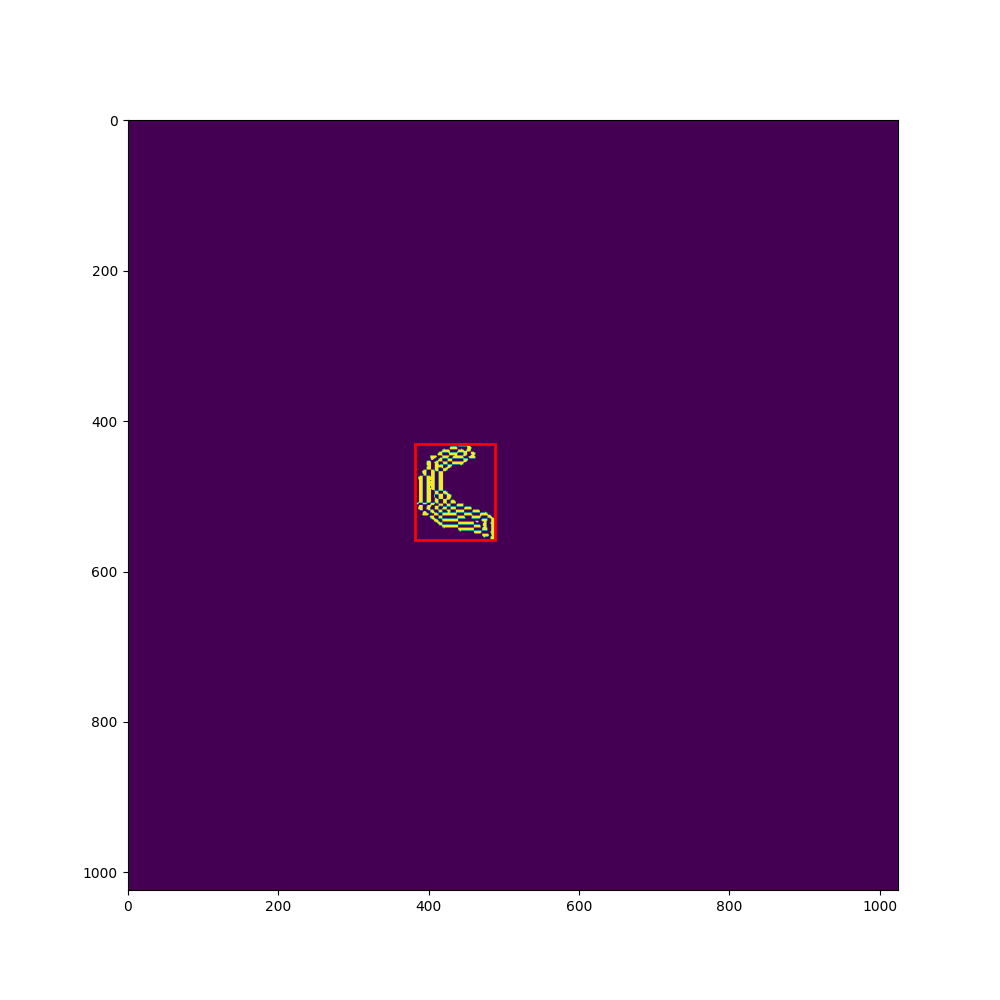

The mask contains non-zero values.
Processing slice 17 of image AHN_0001
[380 421 498 561]


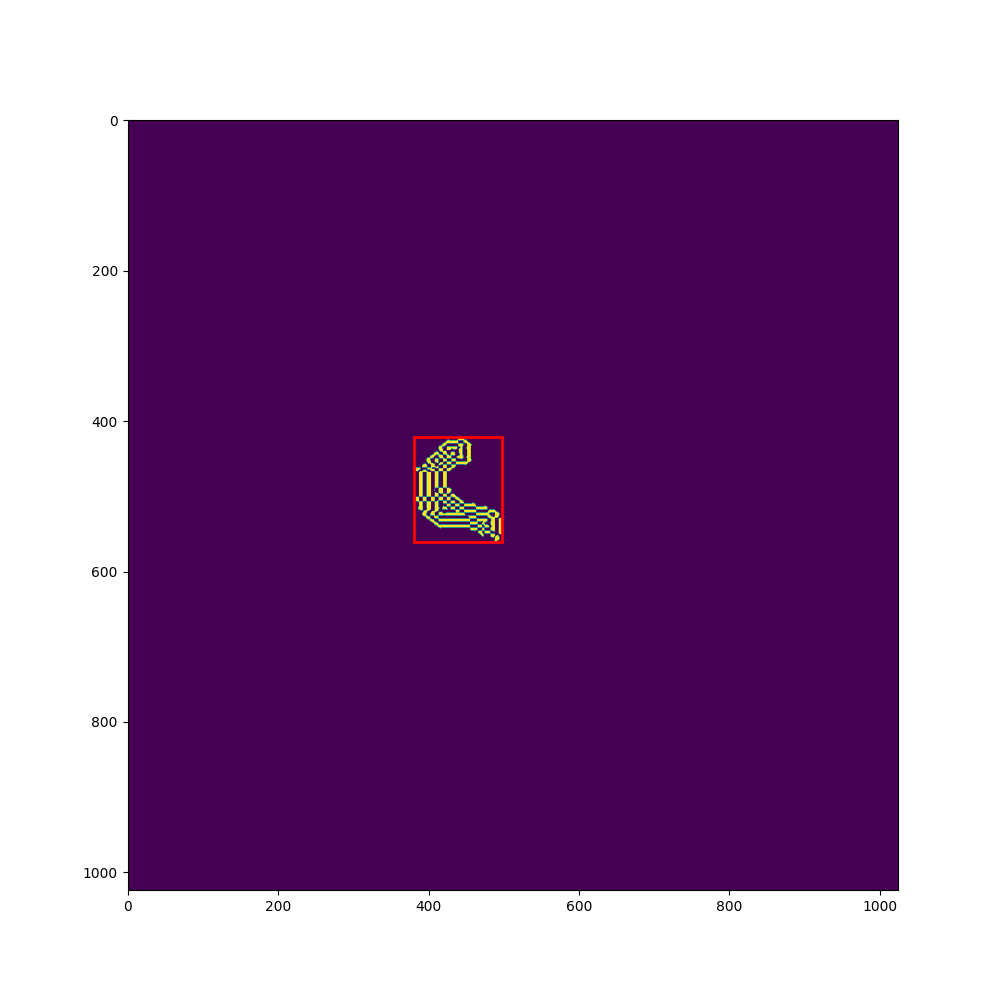

The mask contains non-zero values.
Processing slice 18 of image AHN_0001
[402 425 509 562]


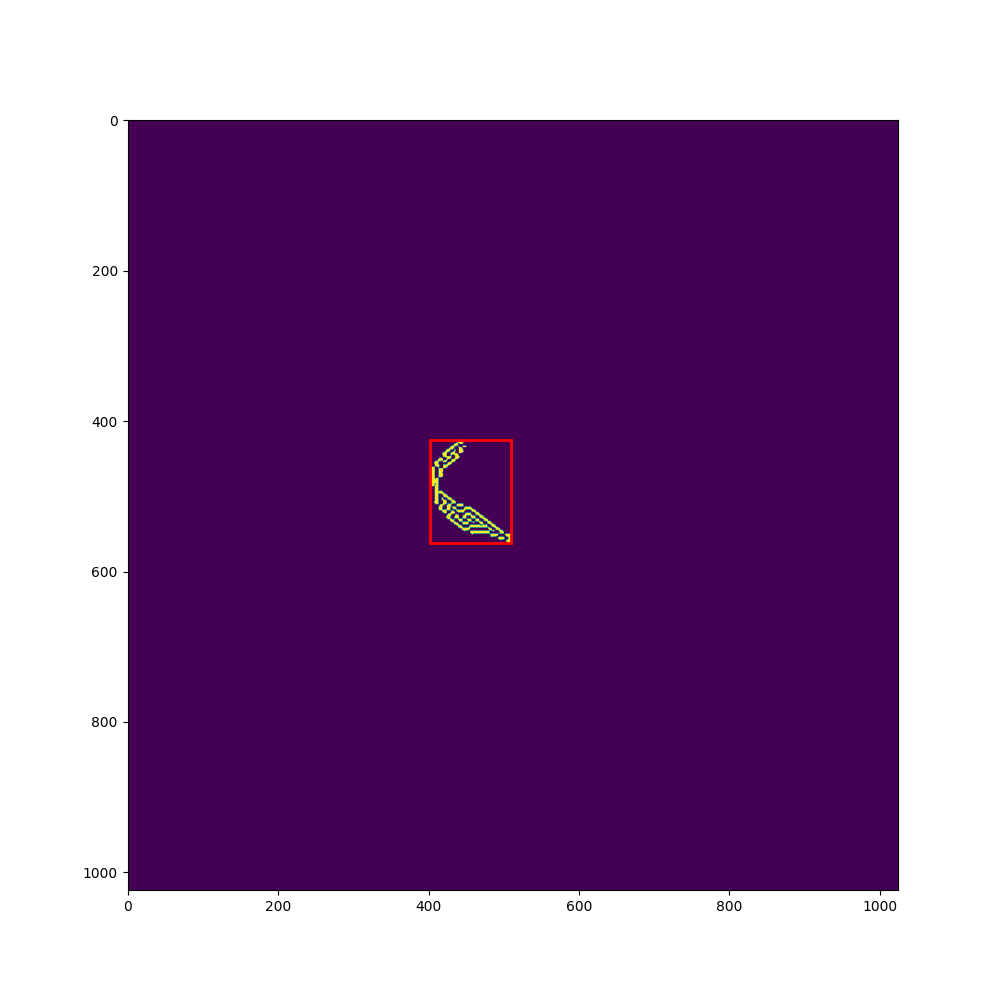

The mask contains non-zero values.
Processing slice 19 of image AHN_0001
[402 446 497 550]


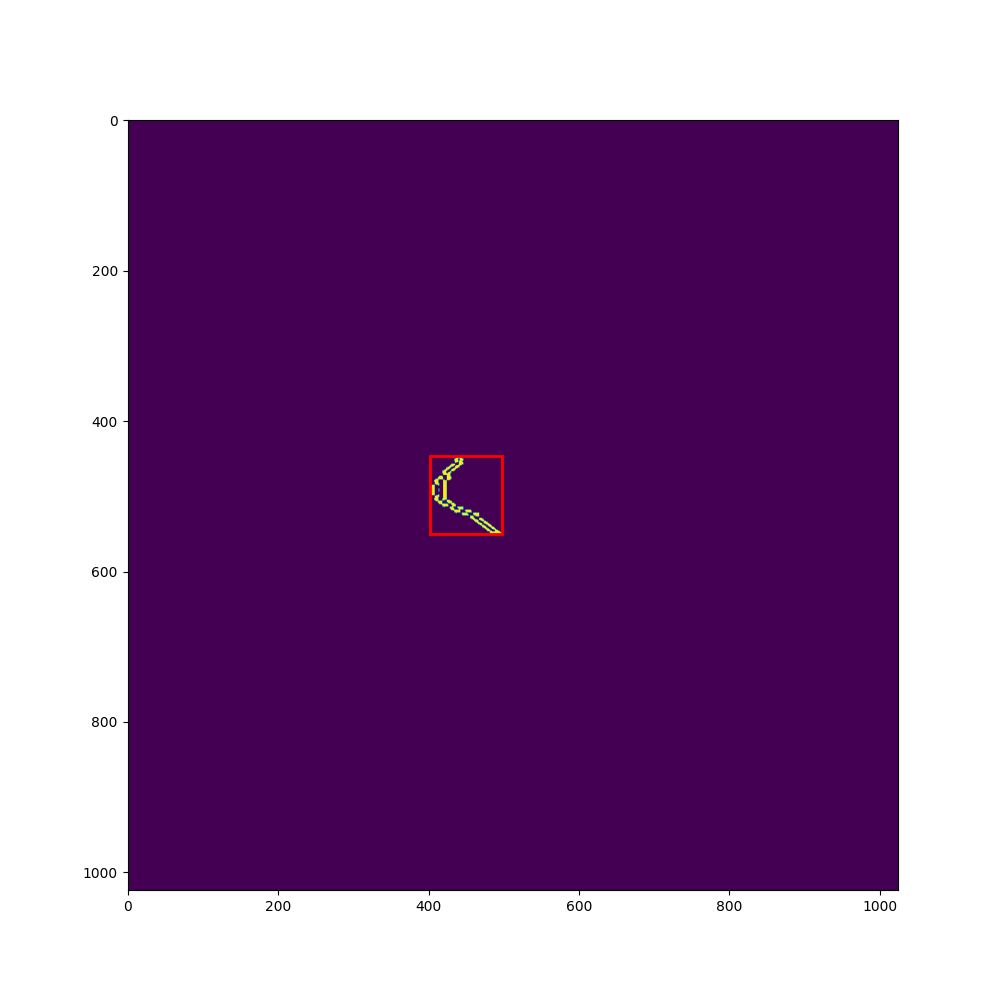

The mask contains non-zero values.
Skipping slice 20 of image AHN_0001: Not enough mask pixels
Skipping slice 21 of image AHN_0001: Not enough mask pixels
Skipping slice 22 of image AHN_0001: Not enough mask pixels
Skipping slice 23 of image AHN_0001: Not enough mask pixels
Skipping slice 24 of image AHN_0001: Not enough mask pixels
Skipping slice 25 of image AHN_0001: Not enough mask pixels


In [34]:
# Loop over images

for nii_file in nii_files[:1]:
    # Extract the image name (without extension) and remove '_0000' suffix if present
    image_name = os.path.basename(nii_file).split('.')[0].replace('_0000', '')
    
    if image_name in mask_dict:  # Check if there is a matching mask file
        mask_path = mask_dict[image_name]

        # Load the image and corresponding mask
        image = nib.load(nii_file).get_fdata()
        mask = nib.load(mask_path).get_fdata()


        for slice_nr in range(image.shape[2]):
            image_data = image[:,:,slice_nr]
            mask_data = mask[:,:,slice_nr]

            if np.sum(mask_data == 1) >= 100:
                print(f"Processing slice {slice_nr} of image {image_name}")

                #Preprocessing    
                image_data_pre = normalization(modality, image_data)
                img_3c, H, W = reshape(image_data_pre)

                img_1024, img_1024_tensor = resize(img_3c)

                mask_1024 = resize_mask(mask_data)

                x_min, x_max, y_min, y_max, box_prompt = create_box_prompt(mask_1024)

                print(box_prompt)
                fig, ax = plt.subplots(figsize=(10,10))
                show_box_prompt(mask_1024, x_min, x_max, y_min, y_max, ax)
                with torch.no_grad():
                    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)


                medsam_seg = medsam_inference(medsam_model, image_embedding, box_prompt, H, W)
                if np.any(medsam_seg != 0):
                    print("The mask contains non-zero values.")
                    save_seg(medsam_seg, mask_path, slice_nr)
                    medsam_seg_resized = resize_mask(medsam_seg)

                   
                    #plt.figure(figsize=(10,10))
                    #plt.gca().cla()
                    #plt.imshow(img_1024)
                    #show_mask(medsam_seg_resized, plt.gca())
                    #show_box_prompt(mask_1024, x_min, x_max, y_min, y_max, plt.gca())
                    #plt.axis('off')
                    #plt.show() 
                else:
                    print("The mask does not contain any non-zero values.")
       
            else:
                print(f"Skipping slice {slice_nr} of image {image_name}: Not enough mask pixels")
    
    else:
            print(f"Warning: No corresponding mask found for {image_name}")


## Evaluation

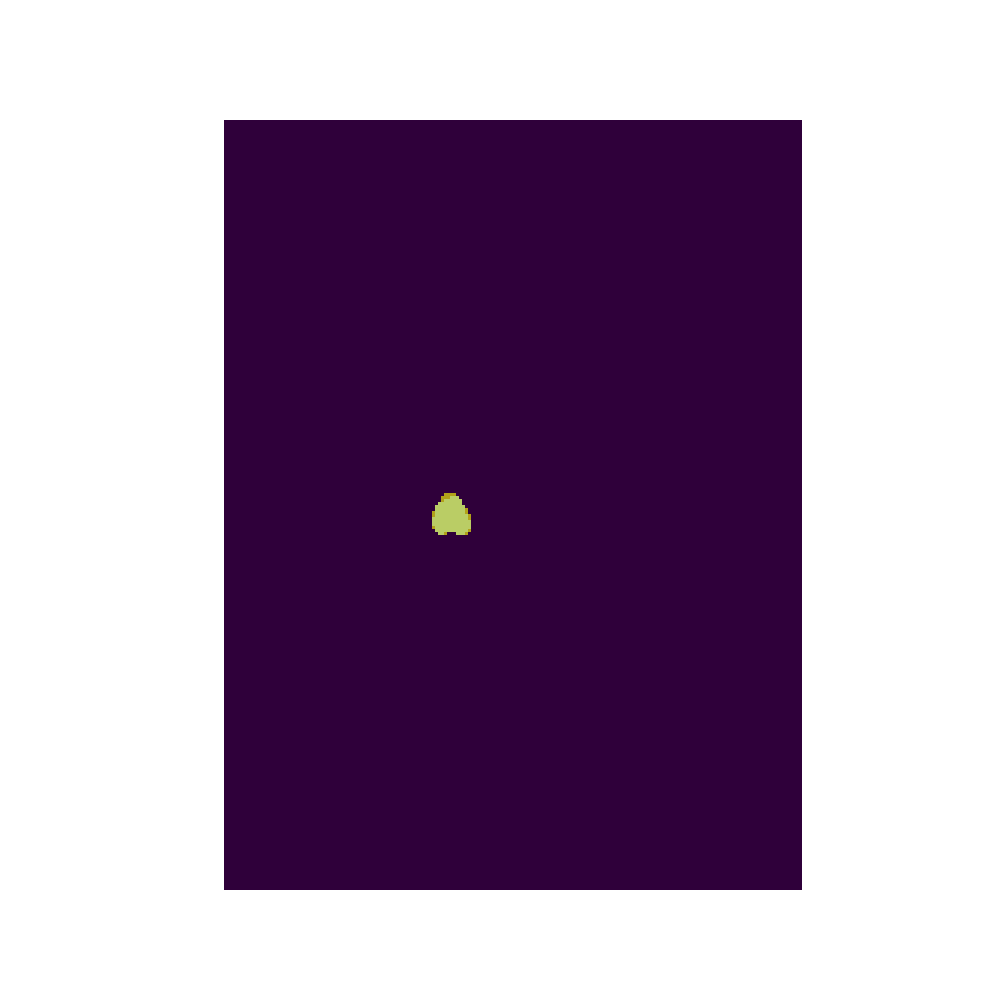

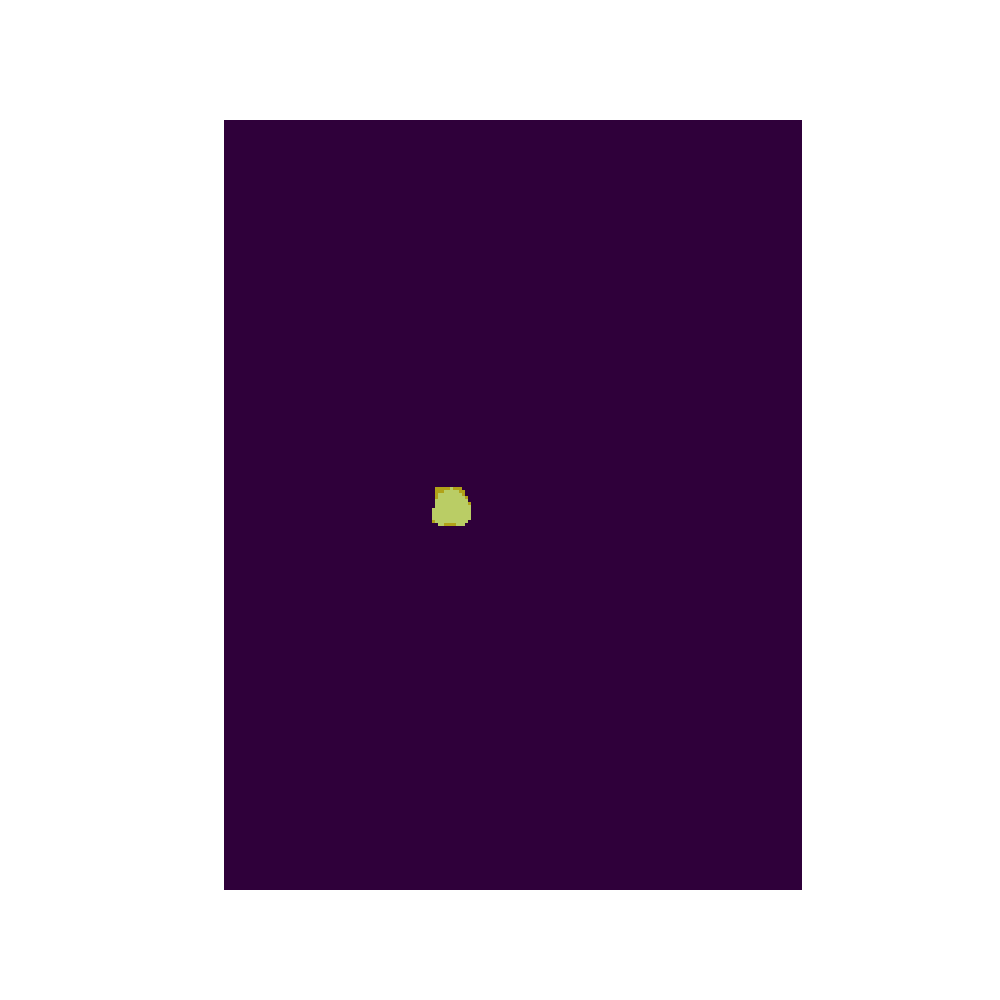

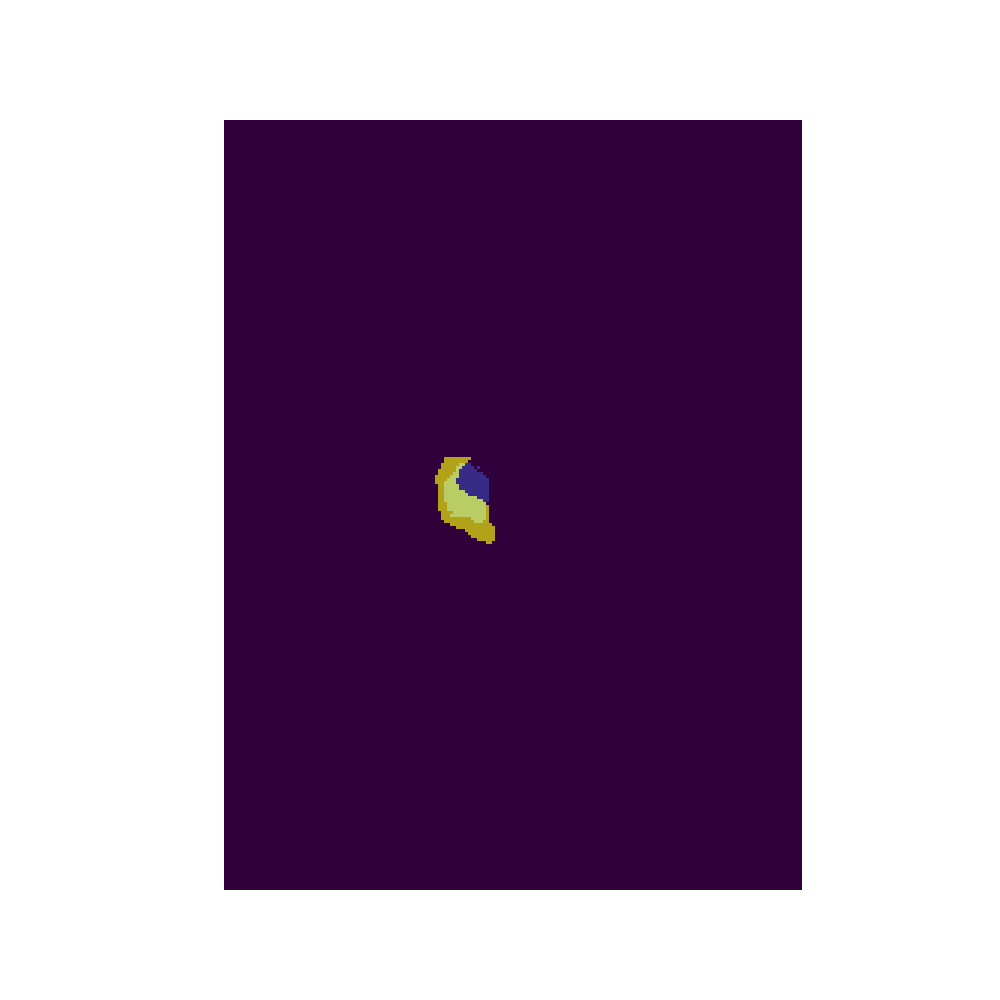

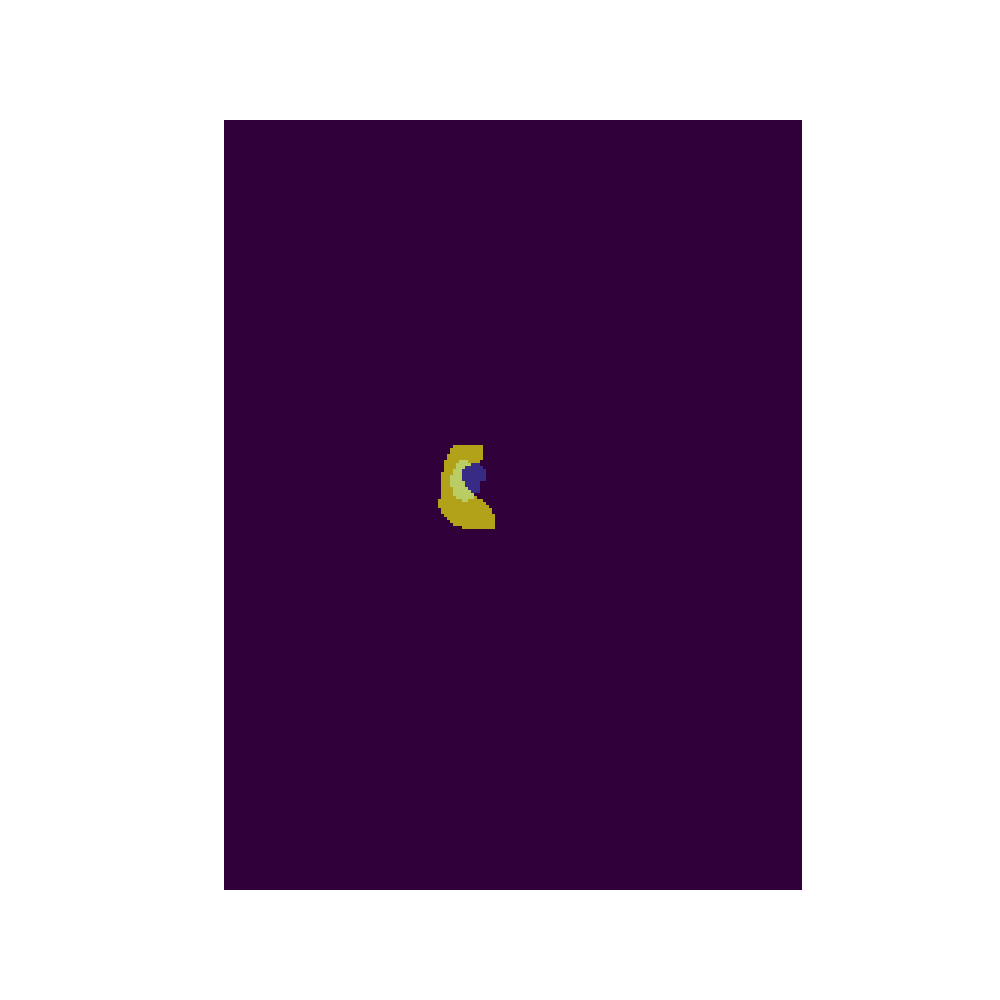

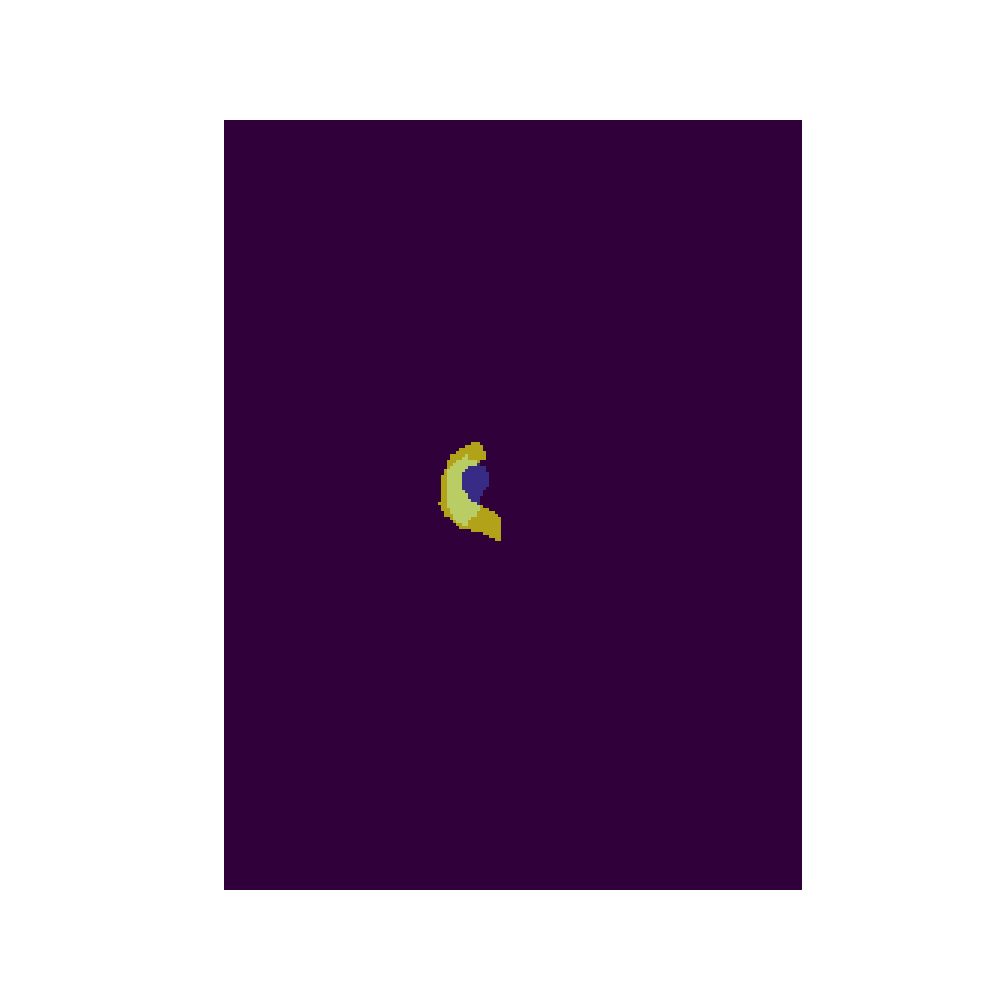

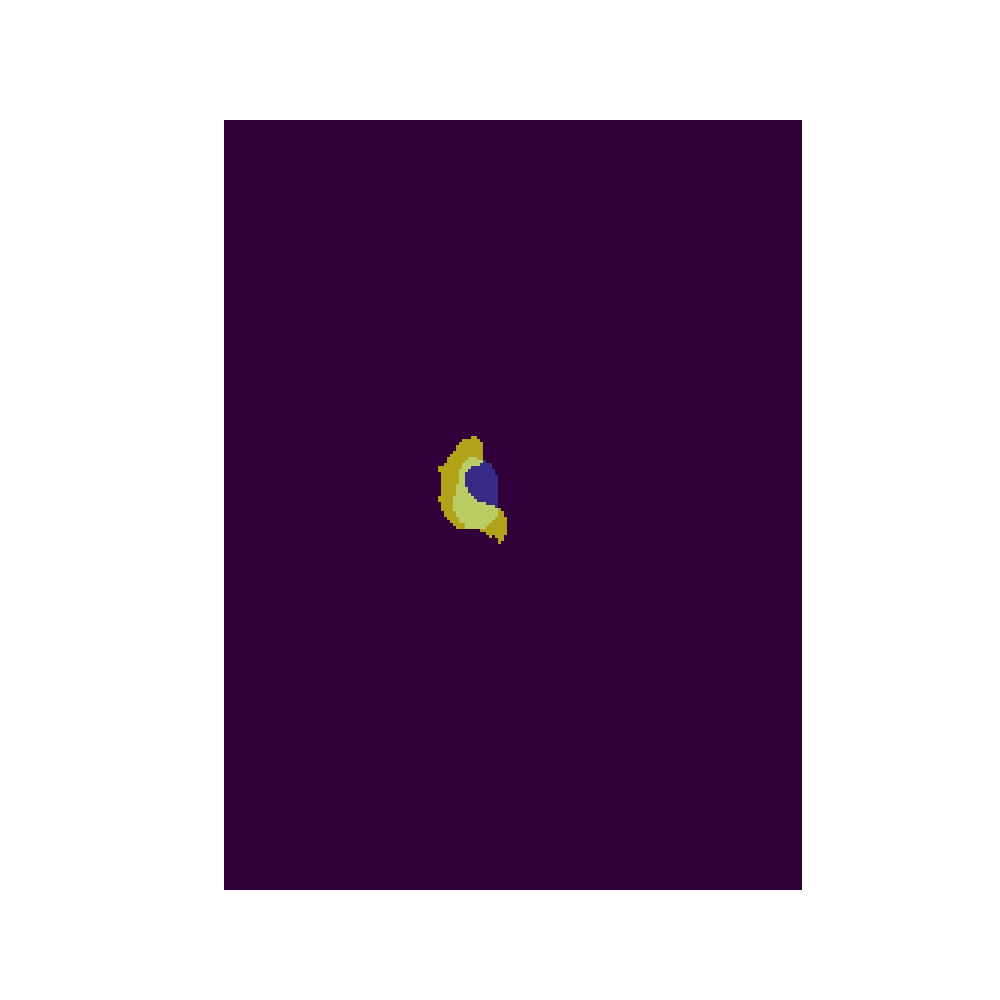

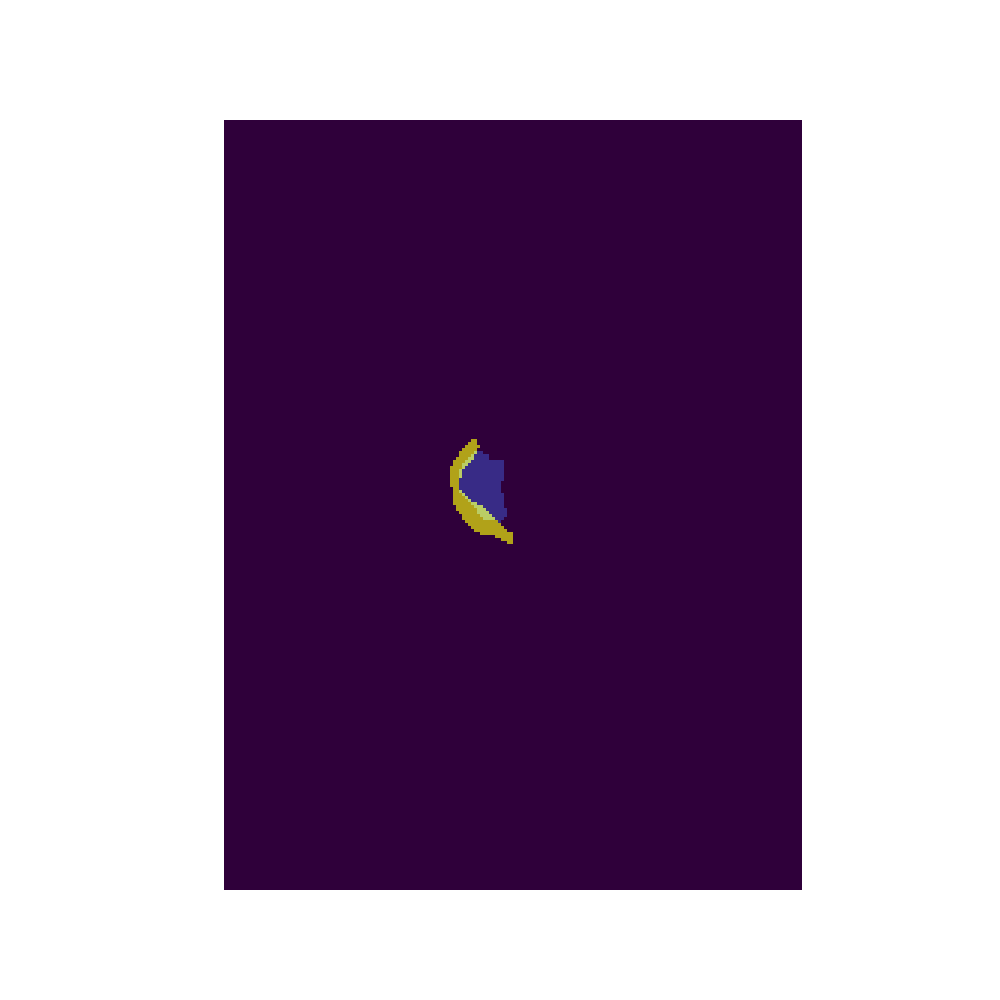

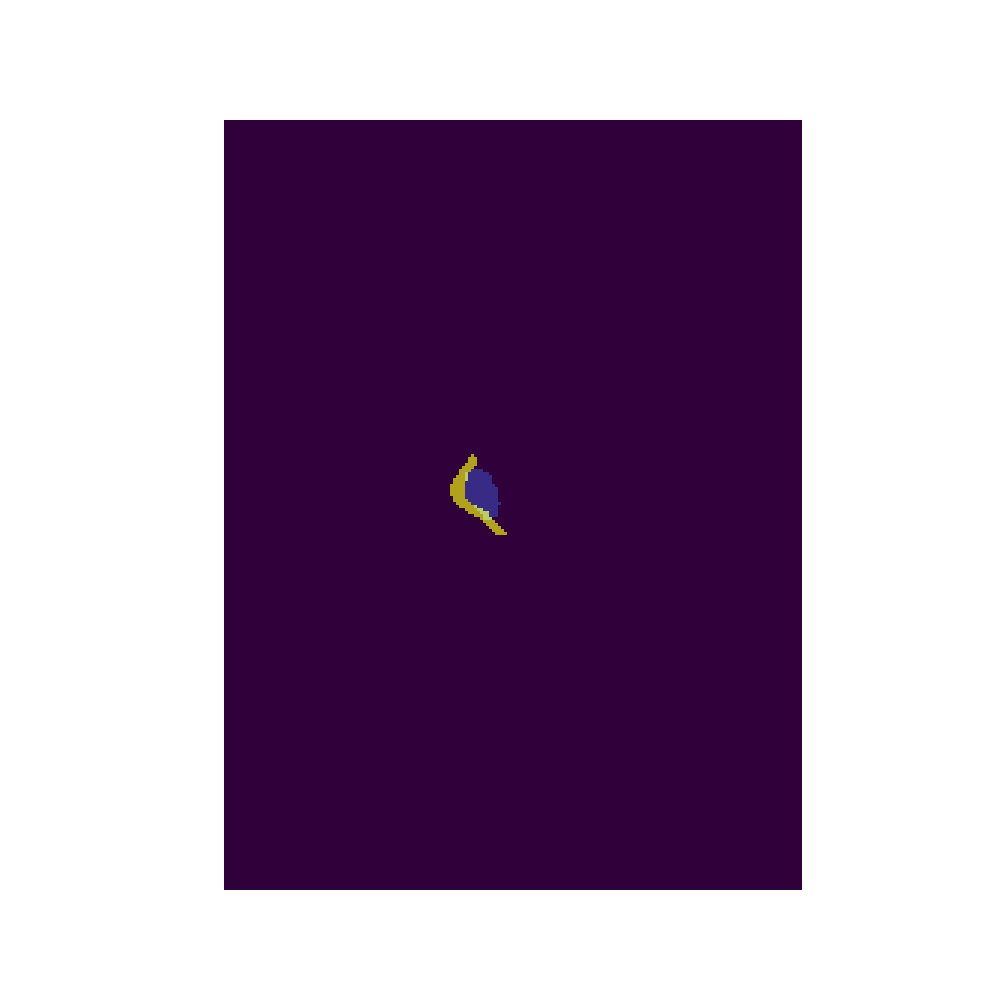

0.4881065865235724
nan
0.37969154320364423


In [13]:
dice_coefficients = []
average_surface_distances = []
ious = []


for mask_file in mask_files[:1]:
    mask = nib.load(mask_file).get_fdata()
    mask_name = os.path.basename(mask_file).split('.')[0]
    parent_folder = os.path.dirname(mask_file)

    # Extract the header information
    nifti = nib.load(mask_file)
    header = nifti.header

    # Get the voxel spacing (pixel dimensions)
    voxel_spacing = header.get_zooms()  ### Assumes that ground truth mask has the same voxel spacing

    for slice_nr in range(mask.shape[2]):
        mask_data = mask[:,:,slice_nr]
        mask_gt = mask_data.astype(bool)  # Convert ground truth mask to boolean
       
        # Construct the filename for the segmentation result
        segmentation_file = os.path.join(parent_folder, f"{mask_name}_slice_{slice_nr}_seg_result.png")
    
        # Check if the file exists
        if os.path.isfile(segmentation_file):
            #print(f"File exists for slice {slice_nr}: {segmentation_file}")

            segmentation = cv2.imread(segmentation_file)
            mask_pred = (segmentation.sum(axis=-1) > 0).astype(bool)  # Convert to binary based on any non-zero value in the channels

            plt.figure(figsize=(10,10))
            plt.gca().cla()
            plt.imshow(mask_gt)
            show_mask(mask_pred, plt.gca())
            plt.axis('off')
            plt.show() 

            dice_coefficient = compute_dice_coefficient(mask_gt, mask_pred)
            dice_coefficients.append(dice_coefficient)

            iou = calculate_iou(mask_pred, mask_gt)
            ious.append(iou)
            
            #surface_distances = compute_surface_distances(mask_gt, mask_pred, voxel_spacing)
            #average_surface_distance = compute_average_surface_distance(surface_distances)
            #average_surface_distances.append(average_surface_distance)
           

        else:
            #print(f"File does not exist for slice {slice_nr}.")
            continue
            

print(np.mean(dice_coefficients))
print(np.mean(average_surface_distances))
print(np.mean(ious))
    